<h3>Pipeline For Data Curation </h3>
<h4>First load all starpep data and separate sequences with non-standard amino acids into a separate list </h4>

In [4]:
from Bio import SeqIO
import re
import pandas as pd
import numpy as np
pattern = re.compile("[^ARNDCEQGHILKMFPSTWYV]") #no B asaparctic acid or Z glutamic acid (or "X" or "O")
standard = []
non_standard= []
for idx, record in enumerate(SeqIO.parse("amp_100_pep_toolbox_raw.fasta", "fasta")):
    if pattern.search(str(record.seq)):
        non_standard.append(idx) #saving the index of the non-standard AAs for future reference
    else:
        standard.append(record.seq)

print("Are there duplicates:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal

print("Number of sequences with only standard AA's: ",len(standard), "\t Number with non-standard AA's",len(non_standard))
sequence_length_dict={'sequences': [str(seq) for seq in standard], 'lengths':[len(seq) for seq in standard]}
pd.DataFrame.from_dict(sequence_length_dict).to_csv('starpep_sequences_and_lengths.csv', index=False)

Are there duplicates: False
Number of sequences with only standard AA's:  42373 	 Number with non-standard AA's 2747


<h4> Then load the uniprot data and separate sequences with standad amino acids into a separate list

In [2]:
pattern = re.compile("[^ARNDCEQGHILKMFPSTWYV]") #no B asaparctic acid or Z glutamic acid (or "X" or "O")
standard = []
non_standard= []
for idx, record in enumerate(SeqIO.parse("uniprot_len_50_std_only_non_antimicrobial.fasta", "fasta")):
    if pattern.search(str(record.seq)):
        non_standard.append(idx) #saving the index of the non-standard AAs for future reference
    else:
        standard.append(record.seq)

print("Are there duplicates:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal
standard = list(set(standard))
print("Are there duplicates after removal?:", len(standard) != len(set(standard))) #sets do not allow duplicate values, check if both list lens are equal

print("Number of sequences with only standard AA's: ",len(standard), "\t Number with non-standard AA's",len(non_standard))
sequence_length_dict={'sequences': [str(seq) for seq in standard], 'lengths':[len(seq) for seq in standard]}
pd.DataFrame.from_dict(sequence_length_dict).to_csv('uniprot_sequences_and_lengths.csv', index=False)

KeyboardInterrupt: 

<h4> Load the function metadata for starpep and re-format it

In [ ]:
df_func = pd.read_csv('sunistar_v1\\sequence_function_link_std_only.csv')
with open('starpep_amps_in_order.txt', 'w') as f:
    for sequence, amp_check in zip(df_func['Sequences'], df_func['Antimicrobial']):
        if amp_check==1:
            f.write('antimicrobial\n')
        else:
            f.write('not_antimicrobial\n')
f.close()

<h4> Now load both created csv's with starpep and uniprot sequences of only standard amino acids and combine to create final dataset

In [5]:
df_uni = pd.read_csv('uniprot_sequences_and_lengths.csv')
df_star = pd.read_csv('starpep_sequences_and_lengths.csv')

#loading the functional data for property predictor
df_func = pd.read_csv('function_full_no_shuff.txt', names=['Antimicrobial'])
df_func["Antimicrobial"] = df_func["Antimicrobial"].map({"antimicrobial":1, "not_antimicrobial":0})

#tie the functional data to starpep and add negative labels to all uniprot data
df_star["Antimicrobial"] = df_func["Antimicrobial"]
df_uni["Antimicrobial"] = 0

df_unistar = pd.concat([df_star,df_uni]) #important to have starpep 1st to keep as many from there as possible!

#keep only max of 7000 sequences for each length
df_sunistar = pd.DataFrame() #small uniprot+starpep = sunistar
for length in range(51):
    cur_len_df = df_unistar.loc[df_unistar['lengths']==length] 
    df_sunistar = df_sunistar.append(cur_len_df[:7000])  

#save datasets
with open('new_sunistar.txt', 'w') as f:
    for seq in df_sunistar['sequences'].to_numpy():
        f.write(seq)
        f.write('\n')  

with open('new_functions.txt', 'w') as f:
    for func in df_sunistar['Antimicrobial'].to_numpy():
        f.write(str(func))
        f.write('\n')

In [6]:
#check some dataset properties
df_test = pd.concat([df_sunistar,df_star])
difference = df_test.shape[0] - df_test['sequences'].drop_duplicates().shape[0]
print("number of starpep peptides in dataset: ",difference)
print("fraction of entire set: {}/{} = {:.3f}".format(difference,df_sunistar.shape[0],difference/df_sunistar.shape[0]) )
print("number of amps in dataset: ",df_sunistar.loc[df_sunistar['Antimicrobial']==1].shape[0])

number of starpep peptides in dataset:  36634
fraction of entire set: 36634/304194 = 0.120
number of amps in dataset:  10841


<h4> Now that we have the full dataset we can split into train and test sets and shuffle the data

In [7]:
import random

sequences=[]
with open('sunistar.txt') as f:
    sequences= [line.strip('\na') for line in f]
f.close()

function_list = list(df_sunistar['Antimicrobial'])

random.seed(0) # set the seed so shuffling is reproducible
random_indices = np.linspace(0,len(sequences)-1, len(sequences)).astype(np.int)
random.shuffle(random_indices)
sequences = [sequences[i] for i in random_indices]
function_list= [function_list[i] for i in random_indices]

with open('peptide_train+test_no_shuff.txt', 'w') as f: 
    for idx, line in enumerate(sequences):
        f.write(str(line)+'\n')
f.close()

with open('peptide_train.txt', 'w') as f:
    for idx,line in enumerate(sequences):
        if idx <round(0.20*len(sequences)):
            continue
        f.write(str(line)+'\n')
f.close()

with open('peptide_test.txt', 'w') as f:
    for idx,line in enumerate(sequences):
        if idx <round(0.20*len(sequences)):
            f.write(str(line)+'\n')
        else:
            break
f.close()

with open('function_train.txt', 'w') as f:
    for idx,line in enumerate(function_list):
        if idx <round(0.20*len(function_list)):
            continue
        f.write(str(line)+'\n')
f.close()

with open('function_test.txt', 'w') as f:
    for idx,line in enumerate(function_list):
        if idx <round(0.20*len(function_list)):
            continue
        f.write(str(line)+'\n')
f.close()


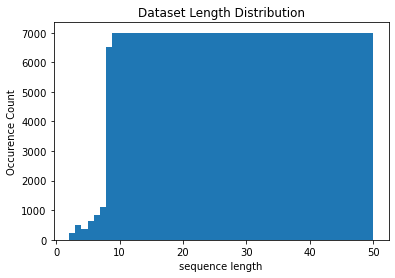

In [9]:
import matplotlib.pyplot as plt
plt.title("Dataset Length Distribution")
plt.xlabel("sequence length")
plt.ylabel("Occurence Count")
plt.hist(df_sunistar['lengths'], bins=49,)
plt.savefig('dataset_length_distribution.png',facecolor='white',transparent=None, dpi=600)